# Ch6-tavily-a-basic-agent

## Get Key Tokens

In [3]:
import os
from pathlib import Path

# Method 1: Using python-dotenv (recommended)
# First install: pip install python-dotenv
try:
    from dotenv import load_dotenv
    
    # Load .env file from home directory
    dotenv_path = Path.home() / '.env'
    load_dotenv(dotenv_path)
    
    # Now you can access environment variables
#    api_key = os.getenv('OPENAI_API_KEY')
#    database_url = os.getenv('DATABASE_URL')
    
    print("Using python-dotenv:")
#    print(f"API Key: {api_key}")
#    print(f"Database URL: {database_url}")
    
except ImportError:
    print("python-dotenv not installed. Install with: pip install python-dotenv")

Using python-dotenv:


## Setup LangGraph

In [7]:
import ast
from typing import Annotated, TypedDict

from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition


@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)


search = TavilySearchResults(max_results=5)
tools = [search, calculator]
model = ChatOpenAI(temperature=0.1).bind_tools(tools)

class State(TypedDict):
    messages: Annotated[list, add_messages]

def model_node(state: State) -> State:
    res = model.invoke(state["messages"])
    return {"messages": res}

builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")

graph = builder.compile()


---
Great question! Here's the call flow:

**OpenAI is called:**
- **Every time** the graph hits the `model_node` 
- This happens at the start, and after every tool execution
- OpenAI decides whether to use tools, respond directly, or continue the conversation

**Tavily is called:**
- **Only when** OpenAI decides it needs to search for information
- OpenAI generates a tool call with the search query
- The graph routes to the `tools` node, which executes the Tavily search

Think of it like this analogy: OpenAI is the "brain" that's always thinking, and Tavily is the "research assistant" that only gets called when the brain says "I need to look something up."

**Example flow for your 30th president question:**
1. **OpenAI called**: "I need to search for info about the 30th president's age at death"
2. **Tavily called**: Searches for "30th president of the United States age at death"
3. **OpenAI called again**: "Based on the search results, Calvin Coolidge was 60 when he died"

**If you asked "What's 2 + 2?":**
1. **OpenAI called**: "I need to use the calculator tool"
2. **Calculator called**: `ast.literal_eval("2 + 2")` → returns `4`
3. **OpenAI called again**: "The answer is 4"

The `tools_condition` function is what decides whether to route to tools or finish - it's like OpenAI's "decision gate."

---
The `@tool` decorator is like a "translator" that converts your regular Python function into something the LLM can understand and use.

Here's what it does:

**Without `@tool`:**
- You have a regular Python function
- The LLM has no idea this function exists
- No way for the LLM to call it

**With `@tool`:**
- Creates a "tool schema" that describes the function to the LLM
- Tells the LLM: "Hey, there's a function called 'calculator' that takes a string query and does math"
- The LLM can now generate tool calls to use it

Think of it like writing a job description - the `@tool` decorator creates a "function description" that the LLM can read and understand.

**Here's what happens behind the scenes:**

```python
# Your function
@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

# The @tool decorator converts this into something like:
{
    "name": "calculator",
    "description": "A simple calculator tool. Input should be a mathematical expression.",
    "parameters": {
        "type": "object",
        "properties": {
            "query": {"type": "string"}
        },
        "required": ["query"]
    }
}
```

That's why when you do `model.bind_tools(tools)`, the LLM knows it can call a function named "calculator" with a string parameter - all thanks to that `@tool` decorator acting as the "interface" between your Python code and the AI model.

## Display Graph

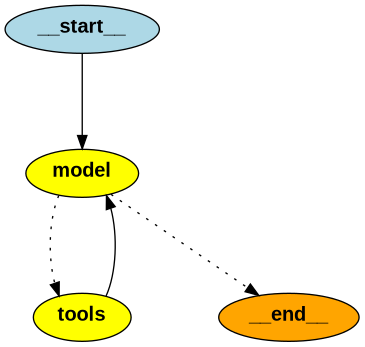

In [8]:
from IPython.display import Image

Image(graph.get_graph().draw_png())

In [9]:
# Example usage

input = {
    "messages": [
        HumanMessage(
            "How old was the 30th president of the United States when he died?"
        )
    ]
}


for c in graph.stream(input):
    print(c)

#
## Advantage here is that we can watch the states run against the LLM one at a time
#

for chunk in graph.stream(input):
    print("=" * 50)
    print(f"Node: {list(chunk.keys())[0]}")
    print("State update:")
    from pprint import pprint
    pprint(chunk)

In [13]:
import json
from typing import Any, Dict
from langchain_core.messages import BaseMessage


def pretty_print_graph_output(graph_output: Dict[str, Any]) -> None:
    """
    Pretty print LangGraph output with proper JSON formatting.
    
    Args:
        graph_output: The dictionary output from graph.stream()
    """
    def message_to_dict(obj):
        """Convert LangChain messages and other objects to JSON-serializable format"""
        if isinstance(obj, BaseMessage):
            return {
                "type": obj.__class__.__name__,
                "content": obj.content,
                "additional_kwargs": obj.additional_kwargs,
                "response_metadata": getattr(obj, 'response_metadata', {}),
                "id": getattr(obj, 'id', None),
                "tool_calls": getattr(obj, 'tool_calls', []),
                "usage_metadata": getattr(obj, 'usage_metadata', {})
            }
        elif hasattr(obj, '__dict__'):
            return {k: message_to_dict(v) for k, v in obj.__dict__.items()}
        elif isinstance(obj, dict):
            return {k: message_to_dict(v) for k, v in obj.items()}
        elif isinstance(obj, list):
            return [message_to_dict(item) for item in obj]
        else:
            return obj
    
    # Convert the graph output to JSON-serializable format
    serializable_output = message_to_dict(graph_output)
    
    # Pretty print with JSON
    print(json.dumps(serializable_output, indent=2, ensure_ascii=False))


In [10]:
def stream_with_state_tracking(graph, input_data):
    """Stream graph execution while tracking the full state"""
    
    print("=" * 50)
    print("INITIAL INPUT:")
    pretty_print_graph_output({"input": input_data})
    print("=" * 50)
    
    current_state = input_data.copy()
    
    for chunk in graph.stream(input_data):
        # Update our state tracking
        for key, value in chunk.items():
            if key == "messages":
                current_state["messages"].extend(value)
            else:
                current_state[key] = value
        
        print(f"Node: {list(chunk.keys())[0]}")
        print("This update:")
        pretty_print_graph_output(chunk)
        print("\nCurrent full state:")
        pretty_print_graph_output(current_state)
        print("=" * 50)

In [11]:
stream_with_state_tracking(graph, input)

INITIAL INPUT:
{
  "input": {
    "messages": [
      {
        "type": "HumanMessage",
        "content": "How old was the 30th president of the United States when he died?",
        "additional_kwargs": {},
        "response_metadata": {},
        "id": "6e6d2457-3be0-4f42-aee2-08438a94e15f",
        "tool_calls": [],
        "usage_metadata": {}
      }
    ]
  }
}
Node: model
This update:
{
  "model": {
    "messages": {
      "type": "AIMessage",
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_mIAD3aJgytPra1qaDDjt8Zoh",
            "function": {
              "arguments": "{\"query\":\"30th president of the United States age at death\"}",
              "name": "tavily_search_results_json"
            },
            "type": "function"
          }
        ],
        "refusal": null
      },
      "response_metadata": {
        "token_usage": {
          "completion_tokens": 27,
          "prompt_tokens": 123,
          "t

In [8]:
#
# Advantage here is that we can watch the states run against the LLM one at a time
# Use JSON pretty printer
#

for chunk in graph.stream(input):
    print("=" * 50)
    print(f"Node: {list(chunk.keys())[0]}")
    print("State update:")
    pretty_print_graph_output(chunk)

Node: model
State update:
{
  "model": {
    "messages": {
      "type": "AIMessage",
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_h9g4vcwM2Fc6bxPBsQtA4PJ9",
            "function": {
              "arguments": "{\"query\":\"30th president of the United States age at death\"}",
              "name": "tavily_search_results_json"
            },
            "type": "function"
          }
        ],
        "refusal": null
      },
      "response_metadata": {
        "token_usage": {
          "completion_tokens": 27,
          "prompt_tokens": 123,
          "total_tokens": 150,
          "completion_tokens_details": {
            "accepted_prediction_tokens": 0,
            "audio_tokens": 0,
            "reasoning_tokens": 0,
            "rejected_prediction_tokens": 0
          },
          "prompt_tokens_details": {
            "audio_tokens": 0,
            "cached_tokens": 0
          }
        },
        "model_name"

In [13]:
for chunk in graph.stream(input):
    print("=" * 50)
    print(f"Node: {list(chunk.keys())[0]}")
    
    # Check if this chunk contains tool calls
    if 'model' in chunk:
        messages = chunk['model']['messages']
        if hasattr(messages, 'tool_calls') and messages.tool_calls:
            print("🔧 TOOL CALLS DETECTED:")
            for tool_call in messages.tool_calls:
                print(f"  - Tool: {tool_call['name']}")
                print(f"  - Args: {tool_call['args']}")
    
    print("State update:")
    pretty_print_graph_output(chunk)

Node: model
🔧 TOOL CALLS DETECTED:
  - Tool: tavily_search_results_json
  - Args: {'query': '30th president of the United States age at death'}
State update:
{
  "model": {
    "messages": {
      "type": "AIMessage",
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_dZ3e5Gn5ZfgGZZBDOUdA0bz6",
            "function": {
              "arguments": "{\"query\":\"30th president of the United States age at death\"}",
              "name": "tavily_search_results_json"
            },
            "type": "function"
          }
        ],
        "refusal": null
      },
      "response_metadata": {
        "token_usage": {
          "completion_tokens": 27,
          "prompt_tokens": 123,
          "total_tokens": 150,
          "completion_tokens_details": {
            "accepted_prediction_tokens": 0,
            "audio_tokens": 0,
            "reasoning_tokens": 0,
            "rejected_prediction_tokens": 0
          },
          

---
Great question! The "decision" happens through the **tool binding** and **conditional routing**. Let me show you exactly where:

## **1. Tool Binding - Where OpenAI learns about available tools:**

```python
tools = [search, calculator]
model = ChatOpenAI(temperature=0.1).bind_tools(tools)  # ← HERE!
```

The `.bind_tools(tools)` call tells OpenAI: "Hey, you have these 2 tools available. You can call them if needed."

Behind the scenes, this converts your tools into a schema that OpenAI understands:
```json
{
  "tools": [
    {
      "type": "function",
      "function": {
        "name": "tavily_search_results_json",
        "description": "Search for information...",
        "parameters": {...}
      }
    },
    {
      "type": "function", 
      "function": {
        "name": "calculator",
        "description": "A simple calculator tool...",
        "parameters": {...}
      }
    }
  ]
}
```

## **2. Decision Point - Where OpenAI chooses:**

```python
def model_node(state: State) -> State:
    res = model.invoke(state["messages"])  # ← OpenAI decides HERE!
    return {"messages": res}
```

When `model.invoke()` is called, OpenAI:
1. Reads the user question
2. Looks at its available tools 
3. **Decides**: "I need to search for this info" 
4. Returns an `AIMessage` with `tool_calls` containing the Tavily search

## **3. Routing Logic - Where the graph routes to tools:**

```python
builder.add_conditional_edges("model", tools_condition)  # ← HERE!
```

The `tools_condition` function (from LangGraph) checks:
- If OpenAI returned tool calls → route to "tools" node
- If no tool calls → conversation ends

## **The analogy:**
Think of it like giving someone a toolbox and asking them to fix something:
1. **bind_tools()** = "Here's your toolbox with a hammer and screwdriver"
2. **model.invoke()** = Person looks at the problem and thinks "I need the hammer"
3. **tools_condition** = "Oh, they picked a tool, so route them to the workshop"

**OpenAI's "decision" is built into the LLM itself** - it's trained to analyze the input and determine which tools (if any) would help answer the question.

---
You're absolutely correct - you see only **one** tool call because OpenAI **chose** to only use **one** of your two available tools!

## **You have 2 tools available:**
1. `tavily_search_results_json` (Tavily search)
2. `calculator` (your math function)

## **But OpenAI only used 1 tool:**
- **Used**: Tavily search to find info about the 30th president
- **Didn't use**: Calculator (even though it was available)

## **Why didn't it use the calculator?**

OpenAI did the math in its head instead of using your calculator tool:

```
"Calvin Coolidge was born on July 4, 1872, and he died on January 5, 1933. 
To calculate his age... 1933 - 1872 = 61 years old"
```

It's like having both a calculator and Google available, but only needing to Google something - you don't use the calculator just because it's there.

## **To force calculator usage, try a harder math problem:**

```python
input_data = {
    "messages": [
        HumanMessage("What's 847,293 multiplied by 52,847?")
    ]
}
```

**Or combine them:**
```python
input_data = {
    "messages": [
        HumanMessage("Search for when Einstein was born and died, then calculate how old he was.")
    ]
}
```

The LLM is smart enough to only use tools when it actually needs them - simple subtraction like `1933 - 1872` doesn't require the calculator tool, but complex math or search queries do!

---
Looking at your execution trace, here's where the OpenAI and Tavily calls happen:

## **OpenAI Calls (2 times):**

**1st OpenAI Call** - In the first `Node: model`:
- OpenAI receives the user question about the 30th president
- Decides it needs to search for information
- Returns a tool call request for `tavily_search_results_json`
- See the `"tool_calls"` section with the search query

**2nd OpenAI Call** - In the second `Node: model`:
- OpenAI receives the search results from Tavily
- Processes the information and provides the final answer
- Notice `"tool_calls": []` (empty) - no more tools needed
- Returns the final response about Calvin Coolidge being 61

## **Tavily Call (1 time):**

**Tavily Call** - In the `Node: tools`:
- Executes the search query: `"30th president of the United States age at death"`
- Returns 5 search results (you can see the Wikipedia articles, Britannica, etc.)
- This becomes a `ToolMessage` that gets fed back to OpenAI

## **The Flow:**
```
User Question 
    ↓
[OpenAI] → "I need to search for this info" → Tool Call Request
    ↓
[Tavily] → Searches web → Returns search results
    ↓  
[OpenAI] → "Based on search results, Calvin Coolidge was 61" → Final Answer
```

**Fun fact:** Notice the token usage - the second OpenAI call used way more tokens (1,879 input tokens) because it had to process all those search results from Tavily!

The calculator tool never got called because OpenAI did simple math in its head rather than using the tool.

---
Great question! OpenAI selects tools based on **semantic matching** between the tool descriptions and the user's question.

## **How OpenAI decides:**

When you send the tool schema, OpenAI receives something like:

```json
{
  "tools": [
    {
      "name": "tavily_search_results_json",
      "description": "Search for information online",
      "parameters": { "query": "string" }
    },
    {
      "name": "calculator", 
      "description": "A simple calculator tool. Input should be a mathematical expression.",
      "parameters": { "query": "string" }
    }
  ]
}
```

## **The matching process:**

**User question:** "How old was the 30th president when he died?"

**OpenAI's reasoning (simplified):**
1. Analyzes question: *"I need info about a historical figure I might not know"*
2. Looks at tool descriptions:
   - `tavily_search_results_json`: "Search for information online" ✅ **MATCH!**
   - `calculator`: "mathematical expression" ❌ (not a math problem yet)
3. Selects Tavily and generates the call

## **It's all about the descriptions:**

```python
@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    # ↑ THIS STRING is what OpenAI uses to decide!
    return ast.literal_eval(query)
```

## **Example of OpenAI's internal decision process:**

```
Question: "How old was the 30th president when he died?"
↓
Analysis: "I need factual information about a person"
↓
Tool matching:
- "Search for information online" → Highly relevant!
- "mathematical expression" → Not relevant yet
↓
Decision: Use Tavily search
```

**The LLM is essentially doing "semantic similarity"** between your question and the tool descriptions, then picking the best match. It's like having a smart assistant who reads job descriptions and picks the right person for the task!

This is why good tool descriptions are crucial - they're literally the "instructions" that help OpenAI pick the right tool.

`Annotated` is a Python typing feature that lets you attach **metadata** to type hints. Here's what it does:

## **Basic syntax:**
```python
Annotated[Type, metadata1, metadata2, ...]
```

## **In your LangGraph example:**
```python
class State(TypedDict):
    messages: Annotated[list, add_messages]
    #          ↑        ↑     ↑
    #      Annotated   type  metadata
```

This means:
- **Type**: `messages` is a `list`
- **Metadata**: LangGraph should use the `add_messages` function when updating this field

## **What LangGraph does with this:**

Without `Annotated`:
```python
# Normal behavior - replacement
state["messages"] = [message1]
state["messages"] = [message2]  # message1 is lost!
```

With `Annotated[list, add_messages]`:
```python
# LangGraph sees the add_messages metadata and does:
state["messages"] = [message1]
state["messages"] = add_messages([message1], [message2])  # Combines them!
# Result: [message1, message2]
```

## **The analogy:**
Think of `Annotated` like a **sticky note** on a variable:
- The variable is still a `list` (type checking works normally)
- But LangGraph reads the sticky note (`add_messages`) for special instructions

## **Other LangGraph examples:**
```python
class State(TypedDict):
    messages: Annotated[list, add_messages]      # Append messages
    counter: Annotated[int, operator.add]       # Add numbers together  
    data: dict                                   # Regular replacement
```

**Key insight:** `Annotated` doesn't change the runtime type - `messages` is still just a `list`. It's purely metadata that frameworks like LangGraph can read and act upon!

---
This function is the **"AI brain"** node in your LangGraph workflow. Let me break it down:

## **What it does:**

```python
def model_node(state: State) -> State:
    res = model.invoke(state["messages"])  # Call OpenAI with conversation history
    return {"messages": res}               # Return OpenAI's response
```

## **Step by step:**

**Input**: Gets the current state (conversation history so far)
```python
state = {
    "messages": [
        HumanMessage("How old was the 30th president when he died?")
    ]
}
```

**Processing**: Calls OpenAI with the conversation
```python
res = model.invoke(state["messages"])
# Sends conversation to OpenAI, gets back an AIMessage
```

**Output**: Returns just the new message in a state update format
```python
return {"messages": res}  # res is an AIMessage
```

## **The analogy:**
Think of `model_node` like a **translator booth** at the UN:
- Takes in the conversation history 
- Sends it to the AI "translator" (OpenAI)
- Returns what the AI "said back"

## **Why return `{"messages": res}` instead of just `res`?**

LangGraph expects **state updates** in dictionary format:
```python
# LangGraph needs this format:
{"messages": AIMessage(...)}

# Not this:
AIMessage(...)
```

## **What `res` contains:**
- **If no tools needed**: AIMessage with final answer
- **If tools needed**: AIMessage with tool_calls (like your Tavily search)

## **The flow:**
```
Conversation History → model_node → OpenAI → AIMessage → Back to Graph
```

This function is essentially the "thinking" step where OpenAI decides what to do next (answer directly, call tools, etc.).

---
Great question! Let me break down each import and what it does in your LangGraph setup:

## **1. `START`**
```python
from langgraph.graph import START
```

**What it is:** A special constant that represents the entry point of your graph.

**What it does:** Marks where execution begins when you run the graph.

```python
builder.add_edge(START, "model")  # Start here → go to model node
```

**Analogy:** Like the "Start" square in a board game - tells the graph where to begin.

---

## **2. `StateGraph`**
```python
from langgraph.graph import StateGraph
```

**What it is:** The main class for building stateful workflows.

**What it does:** Creates a graph where each node can read/modify shared state.

```python
builder = StateGraph(State)  # Create a graph that uses your State structure
```

**Analogy:** Like a blueprint for building a factory where each station (node) can access and update the same shared workspace (state).

---

## **3. `add_messages`**
```python
from langgraph.graph.message import add_messages
```

**What it is:** A special function that appends messages instead of replacing them.

**What it does:** Used in your `Annotated[list, add_messages]` to build conversation history.

```python
messages: Annotated[list, add_messages]  # Use this function for message updates
```

**Analogy:** Like a conversation log that keeps adding new messages rather than erasing old ones.

---

## **4. `ToolNode`**
```python
from langgraph.prebuilt import ToolNode
```

**What it is:** A pre-built node that executes tool calls automatically.

**What it does:** Takes tool calls from the AI and runs the actual tools (Tavily, calculator).

```python
builder.add_node("tools", ToolNode(tools))  # Auto-handles tool execution
```

**Analogy:** Like a robotic assistant that reads tool requests and operates the tools for you.

---

## **5. `tools_condition`**
```python
from langgraph.prebuilt import tools_condition
```

**What it is:** A pre-built routing function that decides where to go next.

**What it does:** Checks if the AI returned tool calls, then routes accordingly.

```python
builder.add_conditional_edges("model", tools_condition)
# If tool calls → go to tools
# If no tool calls → end conversation
```

**Analogy:** Like a traffic controller that reads the AI's "signal" and directs flow to either the tool station or the exit.

## **How they work together:**
```
START → model → tools_condition decides → ToolNode or END
                     ↑                          ↓
                     ← add_messages ←←←←←←←←←←←←
```

Each import handles a specific part of building your AI workflow!

---
Yes! LangGraph has built-in tracing capabilities. Here are several ways to see `tools_condition` in action:The key insights about `tools_condition`:

## **What `tools_condition` actually checks:**
```python
def tools_condition(state):
    last_message = state['messages'][-1]
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        return "tools"  # Route to tools node
    else:
        return None     # End the conversation
```

## **The analogy:**
Think of `tools_condition` like a **mail sorter** at the post office:
- Looks at the last "letter" (AI message)
- If it has "tool call stamps" → sends to "tools department" 
- If no stamps → conversation is "delivered" (ends)

## **Try these examples to see different routing:**

1. **Will route to tools**: `"Search for Python tutorials"`
2. **Will NOT route to tools**: `"Hello, how are you?"`
3. **Will route to calculator**: `"What's 847293 * 652847?"`

The custom `tools_condition` in Method 3 will show you exactly what it's checking and why it makes each routing decision!

In [14]:

# ========================================
# METHOD 1: Stream with verbose debugging
# ========================================
def run_with_debug_tracing(input):
    print("🔍 METHOD 1: Debug Stream Mode")
    print("=" * 60)
    
    input_data = input
    
    # Stream with debug info
    for i, chunk in enumerate(graph.stream(input_data, debug=True)):
        print(f"\n📍 STEP {i+1}:")
        print(f"Node: {list(chunk.keys())[0]}")
        
        # Check what tools_condition would decide
        if 'model' in chunk:
            ai_message = chunk['model']['messages']
            if hasattr(ai_message, 'tool_calls') and ai_message.tool_calls:
                print("🔧 tools_condition decision: ROUTE TO TOOLS")
                print(f"   Tool calls detected: {len(ai_message.tool_calls)}")
                for tc in ai_message.tool_calls:
                    print(f"   - {tc['name']}: {tc['args']}")
            else:
                print("✅ tools_condition decision: END (no tool calls)")
        
        print(f"Chunk keys: {list(chunk.keys())}")

# ========================================
# METHOD 2: Stream with stream_mode="updates"
# ========================================
def run_with_stream_updates():
    print("\n🔍 METHOD 2: Stream Updates Mode")
    print("=" * 60)
    
    input_data = {
        "messages": [HumanMessage("Calculate 847293 * 652847")]
    }
    
    for chunk in graph.stream(input_data, stream_mode="updates"):
        print(f"\n📦 Update from: {list(chunk.keys())[0]}")
        
        # Manually check what tools_condition would do
        if 'model' in chunk:
            messages = chunk['model']['messages']
            print(f"🤖 Model output type: {type(messages).__name__}")
            
            # This is what tools_condition checks internally:
            if hasattr(messages, 'tool_calls') and messages.tool_calls:
                print("🔧 tools_condition logic: HAS TOOL CALLS → Route to 'tools'")
                for tc in messages.tool_calls:
                    print(f"   Tool: {tc['name']}")
            else:
                print("✅ tools_condition logic: NO TOOL CALLS → End conversation")

# ========================================
# METHOD 3: Custom tools_condition with logging
# ========================================
from langgraph.graph import END

def custom_tools_condition_with_logging(state):
    """Custom version of tools_condition that shows its logic"""
    last_message = state['messages'][-1]
    
    print(f"\n🔍 TOOLS_CONDITION CALLED:")
    print(f"   Last message type: {type(last_message).__name__}")
    print(f"   Has tool_calls attr: {hasattr(last_message, 'tool_calls')}")
    
    if hasattr(last_message, 'tool_calls') and last_message.tool_calls:
        print(f"   Tool calls found: {len(last_message.tool_calls)}")
        print(f"   🔧 DECISION: Route to 'tools' node")
        return "tools"
    else:
        print(f"   No tool calls found")
        print(f"   ✅ DECISION: End conversation (return END)")
        return END

def run_with_custom_condition():
    print("\n🔍 METHOD 3: Custom tools_condition with Logging")
    print("=" * 60)
    
    # Build new graph with our logging condition
    builder_custom = StateGraph(State)
    builder_custom.add_node("model", model_node)
    builder_custom.add_node("tools", ToolNode(tools))
    builder_custom.add_edge(START, "model")
    builder_custom.add_conditional_edges("model", custom_tools_condition_with_logging)
    builder_custom.add_edge("tools", "model")
    
    graph_custom = builder_custom.compile()
    
    input_data = {
        "messages": [HumanMessage("What's 123 + 456?")]
    }
    
    for chunk in graph_custom.stream(input_data):
        print(f"📦 {list(chunk.keys())[0]}: {type(chunk[list(chunk.keys())[0]]['messages']).__name__}")

# ========================================
# METHOD 4: Get the actual routing info
# ========================================
def run_with_routing_info(input):
    print("\n🔍 METHOD 4: Stream with Debug Info")
    print("=" * 60)
    
    input_data = input
 
    for chunk in graph.stream(input):
        print("=" * 50)
        print(f"Node: {list(chunk.keys())[0]}")
    
        # Check if this chunk contains tool calls
        if 'model' in chunk:
            messages = chunk['model']['messages']
            if hasattr(messages, 'tool_calls') and messages.tool_calls:
                print("🔧 TOOL CALLS DETECTED:")
            for tool_call in messages.tool_calls:
                print(f"  - Tool: {tool_call['name']}")
                print(f"  - Args: {tool_call['args']}")
    
        print("State update:")
        pretty_print_graph_output(chunk)
    
#    for chunk in graph.stream(input_data, stream_mode="debug"):
#        print(f"Debug chunk: {chunk}")

if __name__ == "__main__":
    # Run different tracing methods
    #run_with_debug_tracing()
    #run_with_stream_updates() 
    #run_with_custom_condition()
    run_with_routing_info(input)  # Uncomment if you want debug mode


🔍 METHOD 4: Stream with Debug Info
Node: model
🔧 TOOL CALLS DETECTED:
  - Tool: tavily_search_results_json
  - Args: {'query': '30th president of the United States age at death'}
State update:
{
  "model": {
    "messages": {
      "type": "AIMessage",
      "content": "",
      "additional_kwargs": {
        "tool_calls": [
          {
            "id": "call_vChRcdrcIny8Jebp1LblefCy",
            "function": {
              "arguments": "{\"query\":\"30th president of the United States age at death\"}",
              "name": "tavily_search_results_json"
            },
            "type": "function"
          }
        ],
        "refusal": null
      },
      "response_metadata": {
        "token_usage": {
          "completion_tokens": 27,
          "prompt_tokens": 123,
          "total_tokens": 150,
          "completion_tokens_details": {
            "accepted_prediction_tokens": 0,
            "audio_tokens": 0,
            "reasoning_tokens": 0,
            "rejected_predictio

---
**The LLM (OpenAI) adds `"finish_reason": "tool_calls"`** - not LangGraph!

## **What happens:**

1. **LangGraph sends** your conversation to OpenAI via `model.invoke()`
2. **OpenAI processes** the request and decides it needs tools
3. **OpenAI returns** an `AIMessage` with:
   - `tool_calls`: The actual tool calls to make
   - `finish_reason`: "tool_calls" (explaining WHY it stopped generating)

## **OpenAI's finish_reason values:**

```python
# What OpenAI can return:
"finish_reason": "stop"        # Normal completion, no tools needed
"finish_reason": "tool_calls"  # Stopped to request tool execution  
"finish_reason": "length"      # Hit token limit
"finish_reason": "content_filter"  # Content was filtered
```

## **The flow:**
```
LangGraph → OpenAI API → Response with finish_reason
    ↓
LangGraph reads finish_reason (but doesn't set it)
    ↓
tools_condition checks tool_calls (ignores finish_reason)
```

## **Analogy:**
Think of `finish_reason` like a **reason code** on a doctor's note:
- Doctor (OpenAI) writes: "Patient needs X-ray" (`finish_reason: "tool_calls"`)
- Nurse (LangGraph) reads the note and routes patient to X-ray department
- The doctor wrote the reason, nurse just follows the instructions

## **LangGraph's role:**
LangGraph **reads** the `tool_calls` field (not `finish_reason`) to decide routing:

```python
# tools_condition logic:
if last_message.tool_calls:  # ← Checks this
    return "tools"
# (ignores finish_reason completely)
```

So OpenAI is telling you "I stopped because I want to call tools" via that finish_reason!

---
**Yes, but with some modifications!** The core LangGraph structure would work, but you'd need to change the LLM provider and possibly adjust tool handling.

## **What you'd need to change:**

### **1. Replace OpenAI with Claude:**
```python
# Instead of:
from langchain_openai import ChatOpenAI
model = ChatOpenAI(temperature=0.1).bind_tools(tools)

# Use:
from langchain_anthropic import ChatAnthropic
model = ChatAnthropic(model="claude-3-sonnet-20240229", temperature=0.1).bind_tools(tools)
```

### **2. Set up Anthropic API key:**
```python
# Environment variable:
ANTHROPIC_API_KEY=your_api_key_here
```

### **3. The LangGraph code stays the same:**
```python
# This part is identical - LangGraph is LLM-agnostic!
builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")
```

## **What might be different:**

### **Tool call format:**
- **OpenAI**: Uses `"finish_reason": "tool_calls"`
- **Claude**: Uses `"stop_reason": "tool_use"` 
- **LangGraph handles this difference automatically!**

### **Response metadata:**
```python
# OpenAI response_metadata:
"model_name": "gpt-3.5-turbo-0125"
"token_usage": {...}

# Claude response_metadata: 
"model": "claude-3-sonnet-20240229"
"usage": {...}
```

## **The analogy:**
Think of LangGraph like a **universal translator** for different AI models:
- Same workflow structure
- Different "accents" (API formats) 
- LangGraph translates between them automatically

## **Complete example for Claude:**

```python
from langchain_anthropic import ChatAnthropic

# Just change this line:
model = ChatAnthropic(
    model="claude-3-sonnet-20240229", 
    temperature=0.1
).bind_tools(tools)

# Everything else stays identical!
```

The beauty of LangGraph is it abstracts away the LLM-specific details, so your workflow logic remains the same regardless of whether you use OpenAI, Claude, or other providers!